In [1]:
import scipy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import math
import matplotlib.patches as patches
import pylab
import shapely.geometry as geometry
import pylab as plt
from matplotlib.path import Path
import scipy.stats

In [2]:
import geopandas as gpd
from matplotlib.path import Path


In [3]:
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
from matplotlib.path import Path

In [4]:
sentinel = xr.open_mfdataset('../Sentinel_data/HMA_sentinel_largeres3/*.nc', combine =  'nested', concat_dim = 'time')

In [5]:
sentinel = sentinel.load()

# Generating Synthetic observations version 2


### Extrapolating out Sentinel-1 observation uncertainty and applying wet snow mask based on Truth surface temperature data

Loading in "Truth" model run

In [6]:
truth = xr.open_dataset('5km_truth.nc')
truth_temp = xr.open_dataset('truth_temp.nc')

In [7]:
truth['temp'] = truth_temp.AvgSurfT_tavg

### Creating mask for where there is actually snow in the Indus basin; should shorten runtime 

In [8]:
snow_mask = truth.SnowDepth_tavg.max('time') > 0

In [9]:
truth = truth.where(snow_mask)

Creating mask for the Indus basin

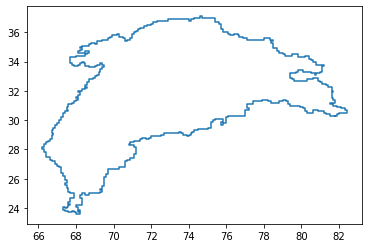

In [10]:
polygon = shapefile.Reader("../files_for_pbs/basins_hma/basins_hma.shp")
polygon = polygon.shapes()
indus = polygon[4]
listx = []
listy = []
for xNew,yNew in indus.points:
    listx.append(xNew)
    listy.append(yNew)
plt.plot(listx,listy)
plt.show()
listx = np.array(listx).reshape([837, 1])
listy = np.array(listy).reshape([837, 1])
coords = np.hstack([listx, listy])
pp = coords.tolist()
poly_path = Path(pp)

In [11]:
listx = np.array(listx).reshape([837, 1])
listy = np.array(listy).reshape([837, 1])
coords = np.hstack([listx, listy])
pp = coords.tolist()
poly_path = Path(pp)

In [12]:
lon = truth.east_west
lat = truth.north_south
x, y = np.meshgrid(lon, lat)
coors_grid = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
era5_mask = poly_path.contains_points(coors_grid)
era5_mask = era5_mask.reshape(len(lat), len(lon))
truth = truth.where(era5_mask)

Reading in the sentinel data.

In [14]:
#sentinel = xr.open_dataset('s1_full_trimmed.nc')

In [13]:
glaciers = sentinel.flags_upd != 2

In [14]:
sentinel = sentinel.where(glaciers)

/global/home/users/cbachand/.conda/envs/reanalysis-sd/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-22-109c939a40b0>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(sentinel.lon, sentinel.lat, sentinel.snd_upd.mean('time'))


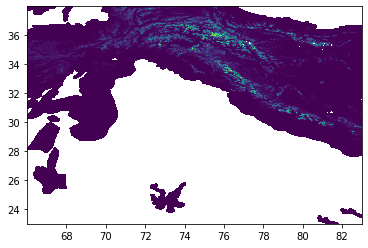

In [22]:
plt.pcolor(sentinel.lon, sentinel.lat, sentinel.snd_upd.mean('time'))

/global/home/users/cbachand/.conda/envs/reanalysis-sd/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


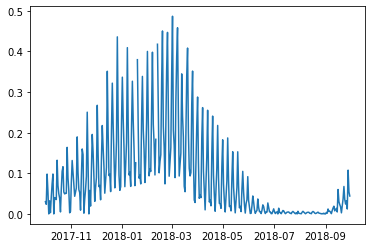

In [23]:
plt.plot(sentinel.time, sentinel.snd_upd.mean(['lon', 'lat']))

Changing WY2018 days to WY2017. Actual WY2017 S1 data is very sparse, which is why WY2018 dictates the frequency of synthetic observations

In [15]:
sent_time = sentinel.time.values
delta = np.timedelta64(365, "D")
sent_time2017 = sent_time -delta

Selecting days from the "truth" run that actually have S1 data

In [16]:
era5_obs_SD = truth.sel(time= sent_time2017)
era5_obs_SD = era5_obs_SD.load()

In [17]:
wet_snow = (truth.temp >= 272.5) & (truth.temp <= 273.5)

In [18]:
era5_obs_SD = era5_obs_SD.SnowDepth_tavg

In [19]:
era5_obs_SD = era5_obs_SD.where(~wet_snow)

In [20]:
sentinel = sentinel.load()
era5_obs_SD = era5_obs_SD.load()

In [23]:
False + 5

5

In [21]:
True * 5

5

In [25]:
 for n in np.arange(len(era5_obs_SD.north_south)):
    for e in np.arange(len(era5_obs_SD.east_west)):
        north_south = era5_obs_SD.north_south[n]
        east_west = era5_obs_SD.east_west[e]
        sent_vect = sentinel.snd_upd.sel({'lon': east_west, 'lat': north_south}, method = 'nearest').values
        era5 = era5_obs_SD.sel({'north_south': north_south, 'east_west': east_west}).values
        sent_nans = sent_vect * 0 #creates mask of 0s and nans 
        low = era5 < 2
        sd_vect = (sent_nans + (low * 0.4) + (~low * era5 * 0.4) )#Adding the nan mask here makes all S1 nans transfer to truth
        bias_vect = (sent_nans + (~low * 0.35))
        rep_vect = era5 + np.random.normal(bias_vect, sd_vect) #SD of nan -> nan
        era5_obs_SD[:, n, e] = rep_vect
        
        
        

In [26]:
era5_obs_SD.to_netcdf('5km_obs_stillwet_Jan15.nc')

In [23]:
nans = np.sum(np.isnan(era5_obs_SD) != True, axis = 0)

<ipython-input-32-266f8aef056f>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(nans.east_west, nans.north_south, nans)


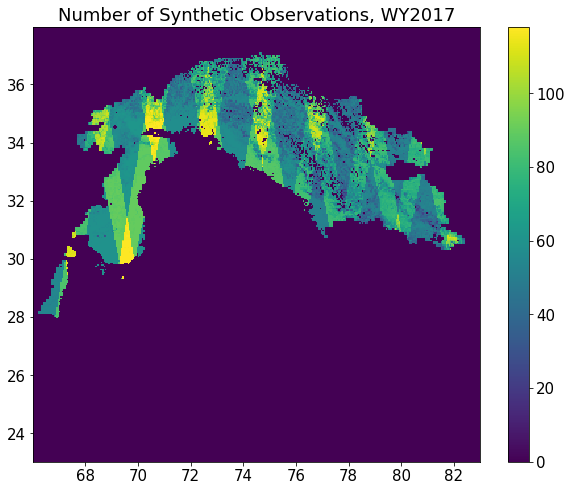

In [32]:
plt.figure(figsize = (10, 8))
plt.pcolor(nans.east_west, nans.north_south, nans)
plt.rc('font', size =15)
plt.title('Number of Synthetic Observations, WY2017')
plt.colorbar()

In [34]:
nans = np.isnan(era5_obs_SD) != True

In [13]:
era5_obs_SD = era5.sel(time= sent_time2017)
#era5_obs_SD = era5_obs.SnowDepth_inst
era5_obs_SD = era5_obs_SD.load()

Generating synthetic ovservations

Iterates through each lat/lon point. For each point, selects the vector of data over time, and adds uncertainty.

The uncertainty scales with snow depth

In [14]:
for n in np.arange(len(era5_obs_SD.north_south)):
    for e in np.arange(len(era5_obs_SD.east_west)):
        north_south = era5_obs_SD.north_south[n]
        east_west = era5_obs_SD.east_west[e]
        sent_vect = sentinel.snd.sel({'lon': east_west, 'lat': north_south}, method = 'nearest').values
        era5 = era5_obs_SD.sel({'north_south': north_south, 'east_west': east_west}).values
        sent_nans = sent_vect * 0 #creates mask of 0s and nans 
        sd_vect = (sent_nans + era5 + 0.1) * 0.15 #Adding the nan mask here makes all S1 nans transfer to truth
        rep_vect = era5 + np.random.normal(-0.01, sd_vect) #SD of nan -> nan
        era5_obs_SD[:, n, e] = rep_vect

Saving synthetic observations as netcdf

In [15]:
era5_obs_SD.to_netcdf('5km_obs_lognormal.nc')

Creating a plot of the "satellite" swaths

In [18]:
nans = np.sum(np.isnan(era5_obs_SD) != True, axis = 0)

In [ ]:
plt.contourf(nans.east_west, nans.north_south, nans)
plt.title('Number of Synthetic Observations, WY2017')
plt.colorbar()

<ipython-input-19-3a517c37a5ea>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(nans.east_west, nans.north_south, nans)


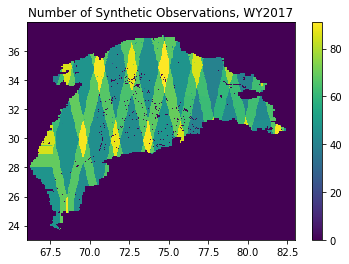

In [19]:
plt.pcolor(nans.east_west, nans.north_south, nans)
plt.title('Number of Synthetic Observations, WY2017')
plt.colorbar()

### Setting normally perturbed observations so that minimum is 0

In [4]:
#lognormal = xr.open_dataset('5km_obs_lognormal.nc')

In [8]:
normal = xr.open_dataset('../files_for_pbs/5km_obs.nc')

In [9]:
nans = np.isnan(normal.SnowDepth_tavg)

In [10]:
test = normal.where(normal.SnowDepth_tavg >= 0, 0)
test = test.where(nans == False)

<ipython-input-55-a46fc78e812b>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(test.east_west, test.north_south, test.SnowDepth_tavg.max('time'))


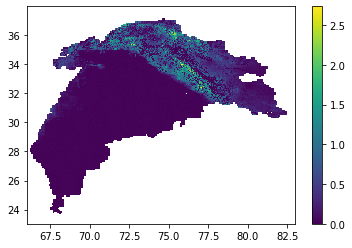

In [55]:
plt.pcolor(test.east_west, test.north_south, test.SnowDepth_tavg.max('time')) 
plt.colorbar()

In [21]:
nor

<xarray.DataArray 'SnowDepth_tavg' (time: 273, north_south: 300, east_west: 340)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2016-10-01 2016-10-02 ... 2017-09-30
  * east_west    (east_west) float32 66.02 66.08 66.12 ... 82.88 82.92 82.98
  * north_south  (north_south) float32 23.02 23.07 23.12 ... 37.88 37.92 37.97

<ipython-input-12-97e242d77865>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(normal.east_west, normal.north_south, normal.SnowDepth_tavg.count('time'))


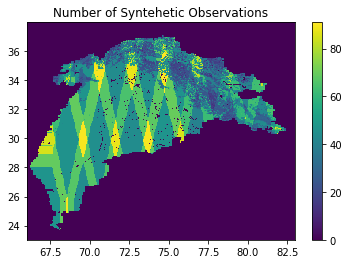

In [12]:

plt.pcolor(normal.east_west, normal.north_south, normal.SnowDepth_tavg.count('time'))
plt.title('Number of Syntehetic Observations')
plt.colorbar()

In [44]:
lognormal.max().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:         ()
Data variables:
    SnowDepth_tavg  float32 5.357>

<ipython-input-19-4dfb7393b654>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(era5.east_west, era5.north_south, era5.max('time'), vmax = 5)


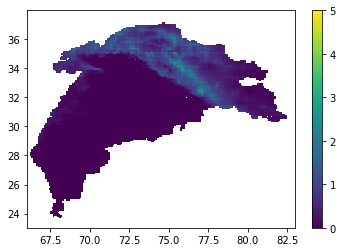

In [19]:
plt.pcolor(era5.east_west, era5.north_south, era5.max('time'), vmax = 5)
plt.colorbar()
plt.title('"Tru"')